In [265]:
import pandas as pd 
import numpy as np 
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.tree import export_graphviz 
from sklearn.model_selection import KFold
import pydot
#cloned into https://github.com/erocarrera/pydot
#from pydot import dot_parser
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import norm
from sklearn.metrics import precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
import random
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
mse = make_scorer(mean_squared_error)
#import h2o

# Which types of companies are multi time donors? 

In [2]:
company = pd.read_csv("company_full_ohe.csv")
company_names = company["company"]
#company["size"] = company["size"].astype("str")
company = pd.get_dummies(company.drop("company", axis = 1))
company["company"] = company_names
#company = company.drop("company", axis = 1)
company["multi_donor"] = 1 - company["one_donation"]
company = company.drop("one_donation", axis = 1)
food = pd.read_csv("no_isf_outliers")
food2 = pd.read_csv("no_ell_outliers")
food3 = pd.read_csv("no_outliers")

### Combining company types based on proportion 

In [3]:
company_food = company[company["type_food"] == 1]["multi_donor"]
company_other = company[company["type_other"] == 1]["multi_donor"]
company_comm = company[company["type_comm"] == 1]["multi_donor"]
company_fin = company[company["type_fin"] == 1]["multi_donor"]
company_soft = company[company["type_soft"] == 1]["multi_donor"]
company_bus = company[company["type_bus"] == 1]["multi_donor"]
company_eh = company[company["type_edu-health"] == 1]["multi_donor"]
company_applied = company[company["type_applied"] == 1]["multi_donor"]
company_web = company[company["type_web"] == 1]["multi_donor"]
company_sale = company[company["type_sale"] == 1]["multi_donor"]
dists_name = ["Food", "Other", "Communication", "Finance", "Software", 
             "Business", "Education-Health", "Applied", "Web", "Sale"]
dists = [company_food, company_other, company_comm, company_fin, company_soft,
        company_bus, company_eh, company_applied, company_web, company_sale]

In [4]:
random.seed(12358)
props = []
for i in range(len(dists)):
    dist = [sum(dists[i].sample(1000, replace = True))/1000 for j in range(1000)]
    props.append(sum(dist)/1000)
props = np.array(props)
print("Company Type and Proportions:")
for i in range(len(props)):
    print(food["type"].unique()[i], props[i])

Company Type and Proportions:
food 0.62908
other 0.647247
comm 0.576585
fin 0.703916
soft 0.812756
bus 0.709983
edu-health 0.571641
applied 0.544972
web 0.578507
sale 0.647638


In [5]:

for i in range(1, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[0]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("Food and " + dists_name[i] + ': {0:0.2f}'.format(
     1 - norm.cdf(abs(z))))
for i in range(2, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[1]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("Other and " + dists_name[i] + ': {0:0.2f}'.format(
     1 - norm.cdf(abs(z))))
for i in range(3, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[2]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("Communication and " + dists_name[i] + ': {0:0.2f}'.format(
      1 - norm.cdf(abs(z))))
for i in range(4, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[3]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("Finance and " + dists_name[i] + ': {0:0.2f}'.format(
      1 - norm.cdf(abs(z))))
for i in range(5, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[4]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("Software and " + dists_name[i] + ': {0:0.2f}'.format(
      1 - norm.cdf(abs(z))))
for i in range(6, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[5]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("Business and " + dists_name[i] + ': {0:0.2f}'.format(
      1 - norm.cdf(abs(z))))
for i in range(7, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[6]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("Education-Health and " + dists_name[i] + ': {0:0.2f}'.format(
      1 - norm.cdf(abs(z))))
for i in range(8, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[7]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("Applied and " + dists_name[i] + ': {0:0.2f}'.format(
      1 - norm.cdf(abs(z))))
for i in range(9, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[8]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("Web and " + dists_name[i] + ': {0:0.2f}'.format(
      1 - norm.cdf(abs(z))))

Food and Other: 0.20
Food and Communication: 0.01
Food and Finance: 0.00
Food and Software: 0.00
Food and Business: 0.00
Food and Education-Health: 0.00
Food and Applied: 0.00
Food and Web: 0.01
Food and Sale: 0.19
Other and Communication: 0.00
Other and Finance: 0.00
Other and Software: 0.00
Other and Business: 0.00
Other and Education-Health: 0.00
Other and Applied: 0.00
Other and Web: 0.00
Other and Sale: 0.49
Communication and Finance: 0.00
Communication and Software: 0.00
Communication and Business: 0.00
Communication and Education-Health: 0.41
Communication and Applied: 0.08
Communication and Web: 0.47
Communication and Sale: 0.00
Finance and Software: 0.00
Finance and Business: 0.38
Finance and Education-Health: 0.00
Finance and Applied: 0.00
Finance and Web: 0.00
Finance and Sale: 0.00
Software and Business: 0.00
Software and Education-Health: 0.00
Software and Applied: 0.00
Software and Web: 0.00
Software and Sale: 0.00
Business and Education-Health: 0.00
Business and Applied:

In [6]:
company.columns

Index(['size_10.0', 'size_1000.0', 'size_10000.0', 'size_10001.0',
       'size_200.0', 'size_50.0', 'size_500.0', 'size_5000.0',
       'state_California', 'state_New York', 'state_underdeveloped',
       'type_applied', 'type_bus', 'type_comm', 'type_edu-health', 'type_fin',
       'type_food', 'type_other', 'type_sale', 'type_soft', 'type_web',
       'company', 'multi_donor'],
      dtype='object')

In [7]:
company["food_other_sale"] = company.iloc[:, [16, 17, 18]].sum(axis = 1)
company["applied_comm_edu/health_web"] = company.iloc[:, [11, 13, 14, 20]].sum(axis = 1)
company["fin_bus"] = company.iloc[:, [12, 15]].sum(axis = 1)
company = company.drop(["type_applied", "type_food", "type_other", "type_sale", "type_comm", 
                       "type_edu-health", "type_web", "type_fin", "type_bus"], axis = 1)

### Combining company sizes based on proportions

In [8]:
random.seed(123578)
company_10 = company[company["size_10.0"] == 1]["multi_donor"]
company_50 = company[company["size_50.0"] == 1]["multi_donor"]
company_200 = company[company["size_200.0"] == 1]["multi_donor"]
company_500 = company[company["size_500.0"] == 1]["multi_donor"]
company_1000 = company[company["size_1000.0"] == 1]["multi_donor"]
company_5000 = company[company["size_5000.0"] == 1]["multi_donor"]
company_10000 = company[company["size_10000.0"] == 1]["multi_donor"]
company_10001 = company[company["size_10001.0"] == 1]["multi_donor"]
dists_name = ["10", "50", "200", "500", "1000", 
             "5000", "10000", "10001"]
dists = [company_10, company_50, company_200, company_500, company_1000,
        company_5000, company_10000, company_10001]
import random
props = []
for i in range(len(dists)):
    dist = [sum(dists[i].sample(1000, replace = True))/1000 for j in range(1000)]
    props.append(sum(dist)/1000)
props = np.array(props)
print("Company Size and Proportions:")
for i in range(len(props)):
    print(dists_name[i] + ": ", props[i])

Company Size and Proportions:
10:  0.583114
50:  0.59315
200:  0.661191
500:  0.645098
1000:  0.900042
5000:  0.591598
10000:  0.500765
10001:  0.445321


In [9]:
for i in range(1, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[0]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("10 and " + dists_name[i] + ': {0:0.2f}'.format(
     1 - norm.cdf(abs(z))))
for i in range(2, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[1]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("50 and " + dists_name[i] + ': {0:0.2f}'.format(
     1 - norm.cdf(abs(z))))
for i in range(3, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[2]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("200 and " + dists_name[i] + ': {0:0.2f}'.format(
     1 - norm.cdf(abs(z))))
for i in range(4, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[3]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("500 and " + dists_name[i] + ': {0:0.2f}'.format(
     1 - norm.cdf(abs(z))))
for i in range(5, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[4]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("1000 and " + dists_name[i] + ': {0:0.2f}'.format(
     1 - norm.cdf(abs(z))))
for i in range(6, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[5]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("5000 and " + dists_name[i] + ': {0:0.2f}'.format(
     1 - norm.cdf(abs(z))))
for i in range(7, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[6]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("10000 and " + dists_name[i] + ': {0:0.2f}'.format(
     1 - norm.cdf(abs(z))))

10 and 50: 0.32
10 and 200: 0.00
10 and 500: 0.00
10 and 1000: 0.00
10 and 5000: 0.35
10 and 10000: 0.00
10 and 10001: 0.00
50 and 200: 0.00
50 and 500: 0.01
50 and 1000: 0.00
50 and 5000: 0.47
50 and 10000: 0.00
50 and 10001: 0.00
200 and 500: 0.22
200 and 1000: 0.00
200 and 5000: 0.00
200 and 10000: 0.00
200 and 10001: 0.00
500 and 1000: 0.00
500 and 5000: 0.01
500 and 10000: 0.00
500 and 10001: 0.00
1000 and 5000: 0.00
1000 and 10000: 0.00
1000 and 10001: 0.00
5000 and 10000: 0.00
5000 and 10001: 0.00
10000 and 10001: 0.01


In [10]:
company.columns

Index(['size_10.0', 'size_1000.0', 'size_10000.0', 'size_10001.0',
       'size_200.0', 'size_50.0', 'size_500.0', 'size_5000.0',
       'state_California', 'state_New York', 'state_underdeveloped',
       'type_soft', 'company', 'multi_donor', 'food_other_sale',
       'applied_comm_edu/health_web', 'fin_bus'],
      dtype='object')

In [11]:
company["size_10/50/5000"] = company.iloc[:, [0, 5, 7]].sum(axis = 1)
company["size_200/500"] = company.iloc[:, [4, 6]].sum(axis = 1)
company = company.drop(["size_10.0", "size_50.0", "size_200.0", "size_500.0", "size_5000.0"], axis = 1)

### Combining Company Location based on Proportions

In [12]:
company

,size_1000.0,size_10000.0,size_10001.0,state_California,state_New York,state_underdeveloped,type_soft,company,multi_donor,food_other_sale,applied_comm_edu/health_web,fin_bus,size_10/50/5000,size_200/500
0,0,0,0,0,1,0,0,32BJ SEIU,0,1,0,0,0,1
1,0,0,0,0,0,1,0,AFIP,0,0,0,1,1,0
2,0,0,0,1,0,0,0,ALL IN,1,1,0,0,1,0
3,0,0,0,1,0,0,0,AT&T Foundry,1,0,1,0,1,0
4,0,0,0,0,1,0,0,Acxiom,1,0,0,1,1,0
5,0,0,0,0,1,0,0,"Adams & Company Real Estate, LLC",1,0,0,1,0,1
6,0,0,0,0,1,0,0,"Addepar, Inc.",1,0,0,1,0,1
7,0,0,0,0,1,0,0,Adore Me,0,1,0,0,0,1
8,0,0,0,1,0,0,0,Aera Technology Inc.,1,0,1,0,0,1
9,0,0,0,0,1,0,0,Airbnb,1,1,0,0,1,0


In [13]:
random.seed(123589)
company_ca = company[company["state_California"] == 1]["multi_donor"]
company_ny = company[company["state_New York"] == 1]["multi_donor"]
company_ud = company[company["state_underdeveloped"] == 1]["multi_donor"]
dists_name = ["CA", "NY", "UD"]
dists = [company_ca, company_ny, company_ud]
props = []
for i in range(len(dists)):
    dist = [sum(dists[i].sample(1000, replace = True))/1000 for j in range(1000)]
    props.append(sum(dist)/1000)
props = np.array(props)
print("Company Size and Proportions:")
for i in range(len(props)):
    print(dists_name[i] + ": ", props[i])

Company Size and Proportions:
CA:  0.674009
NY:  0.655286
UD:  0.299106


In [14]:
for i in range(1, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[0]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("CA and " + dists_name[i] + ': {0:0.2f}'.format(
     1 - norm.cdf(abs(z))))
for i in range(2, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[1]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("NY and " + dists_name[i] + ': {0:0.2f}'.format(
     1 - norm.cdf(abs(z))))


CA and NY: 0.19
CA and UD: 0.00
NY and UD: 0.00


In [15]:
company.columns

Index(['size_1000.0', 'size_10000.0', 'size_10001.0', 'state_California',
       'state_New York', 'state_underdeveloped', 'type_soft', 'company',
       'multi_donor', 'food_other_sale', 'applied_comm_edu/health_web',
       'fin_bus', 'size_10/50/5000', 'size_200/500'],
      dtype='object')

In [16]:
company["state_ca_ny"] = company.iloc[:, [3, 4]].sum(axis = 1)
company = company.drop(["state_California", "state_New York"], axis = 1)

### Looking at whether a company would be a one time donor before their first donation

In [17]:
features = company.drop(["multi_donor", "company"], axis = 1) 
y = company["multi_donor"]
feature_list = list(features.columns)
features = np.array(features)
train_features, test_features, train_labels, test_labels = train_test_split(features, y, test_size = 0.25, random_state = 23156)

In [18]:
features.shape

(242, 11)

In [19]:
feature_list

['size_1000.0',
 'size_10000.0',
 'size_10001.0',
 'state_underdeveloped',
 'type_soft',
 'food_other_sale',
 'applied_comm_edu/health_web',
 'fin_bus',
 'size_10/50/5000',
 'size_200/500',
 'state_ca_ny']

### Baseline Accuracy

In [263]:
print("Training Accuracy: " + str(sum(train_labels == 1)/train_labels.size))

Training Accuracy: 0.6187845303867403


In [264]:
print("Testing Accuracy: " + str(sum(test_labels == 1)/test_labels.size))

Testing Accuracy: 0.6885245901639344


In [288]:
sum(train_labels == 1)

112

In [289]:
sum(train_labels == 0)

69

In [292]:
sum(train_labels == 1)/train_labels.size

0.6187845303867403

#### Initial Random Forest with Default Settings

In [265]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 12356)
rf.fit(train_features, train_labels);
predictions = rf.predict(test_features)
overall_accuracy_train = sum(rf.predict(train_features) == train_labels)/len(train_labels)
precision_accuracy_train = precision_score(train_labels, rf.predict(train_features))
recall_accuracy_train = recall_score(train_labels, rf.predict(train_features))
overall_accuracy_test = sum(rf.predict(test_features) == test_labels)/len(test_labels)
precision_accuracy_test = precision_score(test_labels, rf.predict(test_features))
recall_accuracy_test = recall_score(test_labels, rf.predict(test_features))

print("Training Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_train))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_train))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_train))
print("Testing Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_test))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_test))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_test))

Training Accuracy
Overall Accuracy: 0.67
Precision Score: 0.70
Recall Score: 0.81
Testing Accuracy
Overall Accuracy: 0.69
Precision Score: 0.74
Recall Score: 0.83


In [266]:
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: state_underdeveloped Importance: 0.13
Variable: size_1000.0          Importance: 0.12
Variable: size_200/500         Importance: 0.12
Variable: state_ca_ny          Importance: 0.12
Variable: applied_comm_edu/health_web Importance: 0.11
Variable: size_10/50/5000      Importance: 0.1
Variable: fin_bus              Importance: 0.08
Variable: food_other_sale      Importance: 0.07
Variable: size_10001.0         Importance: 0.06
Variable: type_soft            Importance: 0.05
Variable: size_10000.0         Importance: 0.04


#### Random Grid Search

In [315]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
max_depth = [int(x) for x in np.linspace(start = 3, stop = 12, num = 10)] 
#max_depth.append(None)
min_samples_split = [int(x) for x in np.linspace(start = 5, stop = 45, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 3, stop = 12, num = 4)]
bootstrap = [True, False] 

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [316]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                              n_iter = 500, cv = 5, verbose = 2, random_state = 12356,
                              n_jobs = -1, scoring = "f1")
rf_random.fit(train_features, train_labels)
rf_random.best_params_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 28.0min finished


{'bootstrap': False,
 'max_depth': 3,
 'max_features': 1,
 'min_samples_leaf': 3,
 'min_samples_split': 22,
 'n_estimators': 1800}

In [320]:
rf = RandomForestClassifier(bootstrap = False,
                            max_depth = 3,
                            max_features = 1,
                            min_samples_leaf = 3,
                            min_samples_split = 22,
                            n_estimators = 1800,
                            random_state = 12356)
rf.fit(train_features, train_labels);
overall_accuracy_train = sum(rf.predict(train_features) == train_labels)/len(train_labels)
precision_accuracy_train = precision_score(train_labels, rf.predict(train_features))
recall_accuracy_train = recall_score(train_labels, rf.predict(train_features))
overall_accuracy_test = sum(rf.predict(test_features) == test_labels)/len(test_labels)
precision_accuracy_test = precision_score(test_labels, rf.predict(test_features))
recall_accuracy_test = recall_score(test_labels, rf.predict(test_features))

print("Training Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_train))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_train))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_train))
print("Testing Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_test))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_test))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_test))

Training Accuracy
Overall Accuracy: 0.66
Precision Score: 0.65
Recall Score: 0.98
Testing Accuracy
Overall Accuracy: 0.72
Precision Score: 0.73
Recall Score: 0.95


#### Grid Search CV 

In [322]:
n_estimators = [1500, 1600, 1800, 2000]
max_features =  [1, 2, 3, 5]
max_depth = [3, 4, 5, 10] 
min_samples_leaf = [3, 5, 10]
min_samples_split =  [20, 21, 22, 23, 24, 25]
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': [True]}
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5,
                          n_jobs = -1, verbose = 2, scoring = "f1") 
grid_search.fit(train_features, train_labels)
grid_search.best_params_

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 34.5min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 44.9min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 57.3min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 71.1min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 85.3min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed: 99.4min finished


{'bootstrap': True,
 'max_depth': 4,
 'max_features': 1,
 'min_samples_leaf': 3,
 'min_samples_split': 20,
 'n_estimators': 2000}

#### Final RF model with best parameters 

In [327]:
rf = RandomForestClassifier(bootstrap = False,
                            max_depth = 4,
                            max_features = 1,
                            min_samples_leaf = 3,
                            min_samples_split = 20,
                            n_estimators = 2000,
                            random_state = 12356)
rf.fit(train_features, train_labels);
overall_accuracy_train = sum(rf.predict(train_features) == train_labels)/len(train_labels)
precision_accuracy_train = precision_score(train_labels, rf.predict(train_features))
recall_accuracy_train = recall_score(train_labels, rf.predict(train_features))
overall_accuracy_test = sum(rf.predict(test_features) == test_labels)/len(test_labels)
precision_accuracy_test = precision_score(test_labels, rf.predict(test_features))
recall_accuracy_test = recall_score(test_labels, rf.predict(test_features))

print("Training Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_train))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_train))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_train))
print("Testing Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_test))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_test))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_test))

Training Accuracy
Overall Accuracy: 0.66
Precision Score: 0.65
Recall Score: 0.98
Testing Accuracy
Overall Accuracy: 0.72
Precision Score: 0.73
Recall Score: 0.95


In [328]:
preds = rf.predict(test_features)
predicted_one_time = [i for i in range(len(preds)) if preds[i] == 1]
predicted_multi_time = [i for i in range(len(preds)) if preds[i] == 0]
true_one_time = [i for i in range(len(test_labels)) if np.array(test_labels)[i] == 1]
true_multi_time = [i for i in range(len(test_labels)) if np.array(test_labels)[i] == 0]
true_positives = len(np.intersect1d(predicted_one_time, true_one_time))
false_positives = len(np.intersect1d(predicted_one_time, true_multi_time))
true_negatives = len(np.intersect1d(predicted_multi_time, true_multi_time))
false_negatives = len(np.intersect1d(predicted_multi_time, true_one_time))
true_negatives

4

\begin{align*}
&- \text{The recall score drastically increased from the initial model from 0.83 to 0.95} \\
&- \text{Final model more likely to identify companies as multi donors than one time donors, precision of model not very accurate} \\ 
\end{align*}

In [329]:
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: state_underdeveloped Importance: 0.21
Variable: state_ca_ny          Importance: 0.2
Variable: size_1000.0          Importance: 0.18
Variable: applied_comm_edu/health_web Importance: 0.13
Variable: fin_bus              Importance: 0.07
Variable: type_soft            Importance: 0.06
Variable: size_10/50/5000      Importance: 0.06
Variable: food_other_sale      Importance: 0.03
Variable: size_200/500         Importance: 0.03
Variable: size_10001.0         Importance: 0.02
Variable: size_10000.0         Importance: 0.0


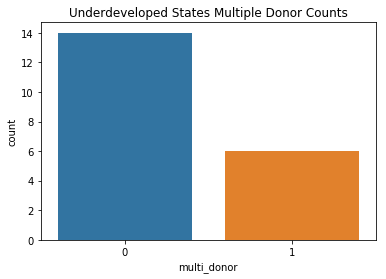

In [330]:
sns.countplot(company[company["state_underdeveloped"] == 1]["multi_donor"]);
plt.title("Underdeveloped States Multiple Donor Counts");


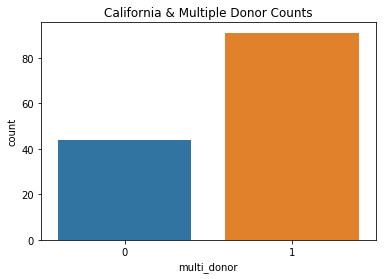

In [340]:
sns.countplot(company[company["state_California"] == 1]["multi_donor"]);
plt.title("California & Multiple Donor Counts");

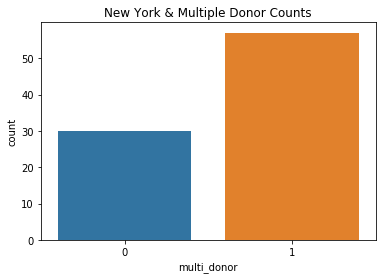

In [341]:
sns.countplot(company[company["state_New York"] == 1]["multi_donor"]);
plt.title("New York & Multiple Donor Counts");

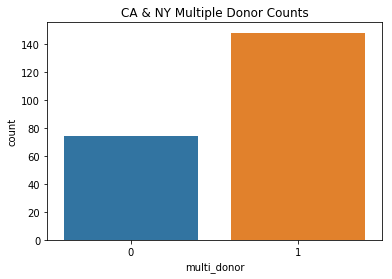

In [335]:
sns.countplot(company[company["state_ca_ny"] == 1]["multi_donor"]);
plt.title("CA & NY Multiple Donor Counts");

In [332]:
ud_len = company[company["state_underdeveloped"] == 1].shape[0]
ud_num_md = sum(company[company["state_underdeveloped"] == 1]["multi_donor"])
ca_ny_len = company[company["state_ca_ny"] == 1].shape[0]
ca_ny_num_md = sum(company[company["state_ca_ny"] == 1]["multi_donor"])
#ny_len = company[company["state_New York"] == 1].shape[0]
#ny_num_md = sum(company[company["state_New York"] == 1]["multi_donor"])
print("Underdeveloped multi-donor proportion: " + str(ud_num_md/ud_len))
print("California and New York multi-donor proportion: " + str(ca_ny_num_md/ca_ny_len))
#print("New York multi-donor proportion: " + str(ny_num_md/ny_len))

Underdeveloped multi-donor proportion: 0.3
California and New York multi-donor proportion: 0.6666666666666666


\begin{align*}
&- \text{The feature with the highest importance (0.2) is state_underdeveloped and it seems that if a company is in a state that's not CA or NY, the company will likely be labeled as a one-time donor.} \\
&- \text{ Out of 20 companies that are in a state other than CA or NY, 6 of which donated more than once} \\
&- \text{Is Replate not as developed in states outside of CA and NY and that's why companies are not as likely to donate multiple times?} \\
\end{align*}

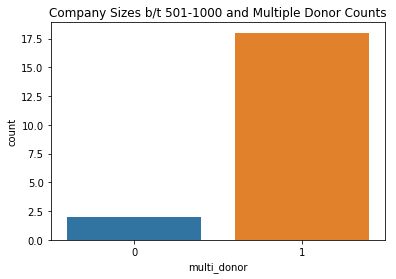

In [333]:
sns.countplot(company[company["size_1000.0"] == 1]["multi_donor"]);
plt.title("Company Sizes b/t 501-1000 and Multiple Donor Counts");

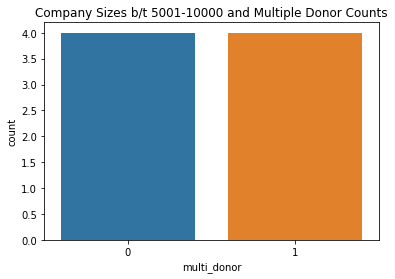

In [363]:
sns.countplot(company[company["size_10000.0"] == 1]["multi_donor"]);
plt.title("Company Sizes b/t 5001-10000 and Multiple Donor Counts");

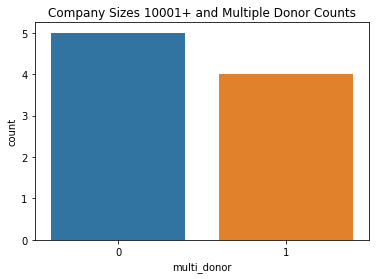

In [364]:
sns.countplot(company[company["size_10001.0"] == 1]["multi_donor"]);
plt.title("Company Sizes 10001+ and Multiple Donor Counts");

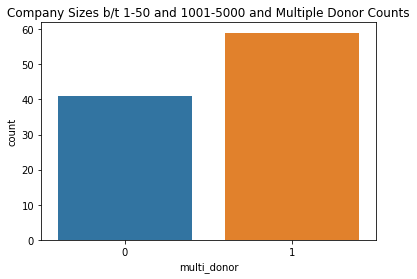

In [367]:
sns.countplot(company[company["size_10/50/5000"] == 1]["multi_donor"]);
plt.title("Company Sizes b/t 1-50 and 1001-5000 and Multiple Donor Counts");

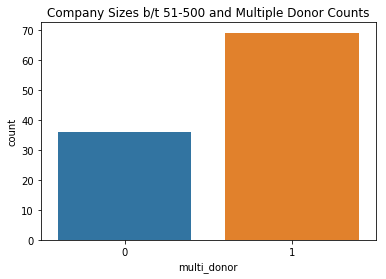

In [368]:
sns.countplot(company[company["size_200/500"] == 1]["multi_donor"]);
plt.title("Company Sizes b/t 51-500 and Multiple Donor Counts");

\begin{align*}
&- \text{The next highest feature in terms of importance (0.14) is size_1000.} \\ 
&- \text{Out of 20 companies that have a size between 501-1000 employees, 18 of them have donated more than once}
\end{align*}

In [360]:

s1000_len = company[company["size_1000.0"] == 1].shape[0]
s1000_num_md = sum(company[company["size_1000.0"] == 1]["multi_donor"])
s10000_len = company[company["size_10000.0"] == 1].shape[0]
s10000_num_md = sum(company[company["size_10000.0"] == 1]["multi_donor"])
s10001_len = company[company["size_10001.0"] == 1].shape[0]
s10001_num_md = sum(company[company["size_10001.0"] == 1]["multi_donor"])
#s5000_len = company[company["size_5000.0"] == 1].shape[0]
#s5000_num_md = sum(company[company["size_5000.0"] == 1]["multi_donor"])
s10_50_5000_len = company[company["size_10/50/5000"] == 1].shape[0]
s10_50_5000_num_md = sum(company[company["size_10/50/5000"] == 1]["multi_donor"])
s200_500_len = company[company["size_200/500"] == 1].shape[0]
s200_500_num_md = sum(company[company["size_200/500"] == 1]["multi_donor"])

print("Size 1-50 and 1001-5000 multi-donor proportion: " + str(s10_50_5000_num_md/s10_50_5000_len))
print("Size 51-500 multi-donor proportion: " + str(s200_500_num_md/s200_500_len))
print("Size 501-1000 multi-donor proportion: " + str(s1000_num_md/s1000_len))
#print("Size 1001-5000 multi-donor proportion: " + str(s5000_num_md/s5000_len))
print("Size 5001-10000 multi-donor proportion: " + str(s10000_num_md/s10000_len))
print("Size 10001+ multi-donor proportion: " + str(s10001_num_md/s10001_len))

Size 1-50 and 1001-5000 multi-donor proportion: 0.59
Size 51-500 multi-donor proportion: 0.6571428571428571
Size 501-1000 multi-donor proportion: 0.9
Size 5001-10000 multi-donor proportion: 0.5
Size 10001+ multi-donor proportion: 0.4444444444444444


\begin{align*}
&- \text{There doesn't seem to be a strong trend in whether a company wuld be a multi donor in the other sizes which is reflected in them having importances lower than 0.1} \\
&- \text{Seems that the proportion of multiple donors increases with size up until 1000 and then the proportion drops down.}
\end{align*}

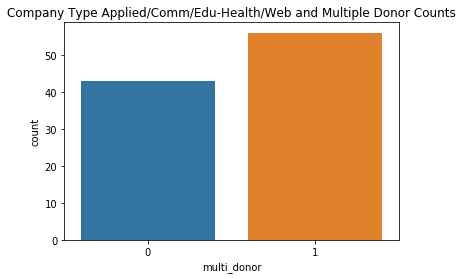

In [380]:
sns.countplot(company[company["applied_comm_edu/health_web"] == 1]["multi_donor"]);
plt.title("Company Type Applied/Comm/Edu-Health/Web and Multiple Donor Counts");

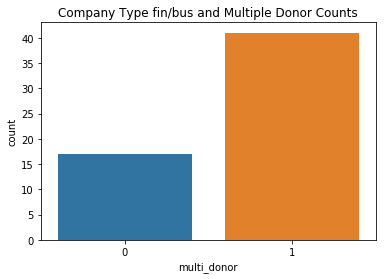

In [383]:
sns.countplot(company[company["fin_bus"] == 1]["multi_donor"]);
plt.title("Company Type fin/bus and Multiple Donor Counts");

In [ ]:
sns.countplot(company[company["applied_comm_edu/health_web"] == 1]["multi_donor"]);
plt.title("Company Type fin_bus and Multiple Donor Counts");

In [372]:
important_features = ["state_underdeveloped", "size_1000.0",
                     "applied_comm_edu/health_web"
                     ]
features = company[important_features]
y = company["multi_donor"]
#features = pd.get_dummies(features)
feature_list = list(features.columns)
features = np.array(features)
train_features, test_features, train_labels, test_labels = train_test_split(features, y, test_size = 0.25, random_state = 23156)

In [374]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = [1, 2, 3]
max_depth = [int(x) for x in np.linspace(start = 2, stop = 6, num = 5)] 
#max_depth.append(None)
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 12, num = 11)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 5, num = 5)]
bootstrap = [True, False] 

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [375]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                              n_iter = 300, cv = 5, verbose = 2, random_state = 12356,
                              n_jobs = -1, scoring = "f1")
rf_random.fit(train_features, train_labels)
rf_random.best_params_

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 15.8min finished


{'bootstrap': True,
 'max_depth': 6,
 'max_features': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 7,
 'n_estimators': 1000}

In [378]:
train_features.shape

(181, 3)

In [376]:
rf = RandomForestClassifier(bootstrap = True,
                            max_depth = 6,
                            max_features = 3,
                            min_samples_leaf = 2,
                            min_samples_split = 7,
                            n_estimators = 1000,
                            random_state = 12356)
rf.fit(train_features, train_labels);
overall_accuracy_train = sum(rf.predict(train_features) == train_labels)/len(train_labels)
precision_accuracy_train = precision_score(train_labels, rf.predict(train_features))
recall_accuracy_train = recall_score(train_labels, rf.predict(train_features))
overall_accuracy_test = sum(rf.predict(test_features) == test_labels)/len(test_labels)
precision_accuracy_test = precision_score(test_labels, rf.predict(test_features))
recall_accuracy_test = recall_score(test_labels, rf.predict(test_features))

print("Training Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_train))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_train))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_train))
print("Testing Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_test))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_test))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_test))

Training Accuracy
Overall Accuracy: 0.65
Precision Score: 0.65
Recall Score: 0.96
Testing Accuracy
Overall Accuracy: 0.72
Precision Score: 0.73
Recall Score: 0.95


In [266]:
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: state_underdeveloped Importance: 0.28
Variable: size_1000.0          Importance: 0.21
Variable: size_200/500         Importance: 0.15
Variable: state_New York       Importance: 0.13
Variable: size_10/50           Importance: 0.12
Variable: state_California     Importance: 0.11


In [252]:
pydot.dot_parser.parse_dot_data

<function dot_parser.parse_dot_data>

In [265]:
import os
tree = rf.estimators_[5]
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, filled = True, rounded = True)
os.system('dot -Tpng tree.dot -o tree.png')
#(graph, ) = pydot.graph_from_dot_file('tree.dot')
#graph.write_png('tree.png')
#pydot.dot_parser.parse_dot_data("tree.dot")

1

### Looking at whether a company would be a one time donor after donation 

In [58]:

def clean_food(x): 
    x = x.drop(["Unnamed: 0", "Unnamed: 0.1", "Id", "id", "number", "street", "city", 
                  "zip", "lat", "lon", "month", "weekday"], axis = 1)
    x["date"] = pd.to_datetime(x["date"])
    x["size"] = x["size"].astype("str")
    x_num_donation = x.groupby("company")["company"].count()
    x_one_donation = (x_num_donation == 1).astype("int")
    x_size = x.groupby("company")["size"].first()
    x_type = x.groupby("company")["type"].first()
    x_state = x.groupby("company")["state"].first()
    x_last_donation_weeks = (np.max(x["date"]) - x.groupby("company")["date"].agg(np.max)).apply(lambda x: x.days)//7
    #x_last_donation = x[x.groupby("company").date.transform("max") == x["date"]].groupby("company").first()["pounds"]
    x_first_donation = x[x.groupby("company").date.transform("min") == x["date"]].groupby("company").first()["pounds"]
    company = pd.DataFrame({"multi_donor": 1 - x_one_donation,
                       "size": x_size, "type": x_type,
                       "state": x_state, 
                        "first_donation": x_first_donation,
                        })
    return pd.get_dummies(company)
company2 = clean_food(food)
company3 = clean_food(food2)
company4 = clean_food(food3)


In [59]:
company2.columns

Index(['first_donation', 'multi_donor', 'size_10.0', 'size_1000.0',
       'size_10000.0', 'size_10001.0', 'size_200.0', 'size_50.0', 'size_500.0',
       'size_5000.0', 'state_California', 'state_New York',
       'state_Underdeveloped', 'type_applied', 'type_bus', 'type_comm',
       'type_edu-health', 'type_fin', 'type_food', 'type_other', 'type_sale',
       'type_soft', 'type_web'],
      dtype='object')

In [60]:
def combine_size_type(x):
    x["food_other_sale"] = x.iloc[:, [18, 19, 20]].sum(axis = 1)
    x["applied_comm_edu/health_web"] = x.iloc[:, [13, 15, 16, 22]].sum(axis = 1)
    x["fin_bus"] = x.iloc[:, [17, 14]].sum(axis = 1)
    x = x.drop(["type_applied", "type_food", "type_other", "type_sale", "type_comm", 
                       "type_edu-health", "type_web", "type_fin", "type_bus"], axis = 1)
    x["size_10/50/5000"] = x.iloc[:, [2, 7, 9]].sum(axis = 1)
    x["size_200/500"] = x.iloc[:, [6, 8]].sum(axis = 1)
    x["state_CA_NY"] = x.iloc[:, [10, 11]].sum(axis = 1)
    x = x.drop(["state_California", "state_New York", "size_10.0", "size_50.0", "size_200.0", "size_500.0", "size_5000.0"], axis = 1)
    return x 
company2 = combine_size_type(company2)
company3 = combine_size_type(company3)
company4 = combine_size_type(company4)

In [61]:
features2 = company2.drop(["multi_donor"], axis = 1) 
y2 = company2["multi_donor"]
feature2_list = list(features2.columns)
features2 = np.array(features2)
train_features2, test_features2, train_labels2, test_labels2 = train_test_split(features2, y2, test_size = 0.25, random_state = 23156)

features3 = company3.drop(["multi_donor"], axis = 1) 
y3 = company3["multi_donor"]
feature3_list = list(features3.columns)
features3 = np.array(features3)
train_features3, test_features3, train_labels3, test_labels3 = train_test_split(features3, y3, test_size = 0.25, random_state = 23156)

features4 = company4.drop(["multi_donor"], axis = 1) 
y4 = company4["multi_donor"]
feature4_list = list(features4.columns)
features4 = np.array(features4)
train_features4, test_features4, train_labels4, test_labels4 = train_test_split(features4, y4, test_size = 0.25, random_state = 23156)


### Baseline 

In [57]:
feature2_list

['first_donation',
 'size_1000.0',
 'size_10000.0',
 'size_10001.0',
 'state_California',
 'state_New York',
 'state_Underdeveloped',
 'type_soft',
 'food_other_sale',
 'applied_comm_edu/health_web',
 'fin_bus',
 'size_10/50/5000',
 'size_200/500',
 'state_CA_NY']

In [45]:
print(sum(train_labels2 == 1)/train_labels2.shape[0], 
      sum(test_labels2 == 1)/test_labels2.shape[0])

0.6742424242424242 0.7777777777777778


In [46]:
print(sum(train_labels3 == 1)/train_labels3.shape[0], 
      sum(test_labels3 == 1)/test_labels3.shape[0])

0.6666666666666666 0.7659574468085106


#### Initial Random Forest 

In [33]:
rf2 = RandomForestClassifier(n_estimators = 1000, random_state = 23456)
rf2.fit(train_features2, train_labels2);
overall_accuracy_train = sum(rf2.predict(train_features2) == train_labels2)/len(train_labels2)
precision_accuracy_train = precision_score(train_labels2, rf2.predict(train_features2))
recall_accuracy_train = recall_score(train_labels2, rf2.predict(train_features2))
overall_accuracy_test = sum(rf2.predict(test_features2) == test_labels2)/len(test_labels2)
precision_accuracy_test = precision_score(test_labels2, rf2.predict(test_features2))
recall_accuracy_test = recall_score(test_labels2, rf2.predict(test_features2))

print("Training Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_train))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_train))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_train))
print("Testing Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_test))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_test))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_test))

Training Accuracy
Overall Accuracy: 0.94
Precision Score: 0.93
Recall Score: 0.99
Testing Accuracy
Overall Accuracy: 0.62
Precision Score: 0.80
Recall Score: 0.69


In [417]:
rf3 = RandomForestClassifier(n_estimators = 1000, random_state = 12356)
rf3.fit(train_features3, train_labels3);
overall_accuracy_train = sum(rf3.predict(train_features3) == train_labels3)/len(train_labels3)
precision_accuracy_train = precision_score(train_labels3, rf3.predict(train_features3))
recall_accuracy_train = recall_score(train_labels3, rf3.predict(train_features3))
overall_accuracy_test = sum(rf3.predict(test_features3) == test_labels3)/len(test_labels3)
precision_accuracy_test = precision_score(test_labels3, rf3.predict(test_features3))
recall_accuracy_test = recall_score(test_labels3, rf3.predict(test_features3))

print("Training Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_train))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_train))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_train))
print("Testing Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_test))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_test))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_test))

Training Accuracy
Overall Accuracy: 0.97
Precision Score: 0.96
Recall Score: 1.00
Testing Accuracy
Overall Accuracy: 0.57
Precision Score: 0.77
Recall Score: 0.64


#### Random Grid Search

In [423]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
max_depth = [int(x) for x in np.linspace(start = 3, stop = 30, num = 10)] 
#max_depth.append(None)
min_samples_split = [int(x) for x in np.linspace(start = 5, stop = 45, num = 9)]
min_samples_leaf = [int(x) for x in np.linspace(start = 3, stop = 12, num = 4)]
bootstrap = [True, False] 

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf2 = RandomForestClassifier()
rf2_random = RandomizedSearchCV(estimator = rf2, param_distributions = random_grid,
                              n_iter = 500, cv = 5, verbose = 2, random_state = 23456,
                              n_jobs = -1, scoring = "f1")
rf2_random.fit(train_features2, train_labels2)
rf2_random.best_params_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 33.3min finished


{'bootstrap': True,
 'max_depth': 12,
 'max_features': 2,
 'min_samples_leaf': 12,
 'min_samples_split': 5,
 'n_estimators': 1200}

In [439]:
rf2 = RandomForestClassifier(bootstrap = True,
                            max_depth = 12,
                            max_features = 2,
                            min_samples_leaf = 12,
                            min_samples_split = 5,
                            n_estimators = 1200,
                            random_state = 23456)
rf2.fit(train_features2, train_labels2);
overall_accuracy_train = sum(rf2.predict(train_features2) == train_labels2)/len(train_labels2)
precision_accuracy_train = precision_score(train_labels2, rf2.predict(train_features2))
recall_accuracy_train = recall_score(train_labels2, rf2.predict(train_features2))
overall_accuracy_test = sum(rf2.predict(test_features2) == test_labels2)/len(test_labels2)
precision_accuracy_test = precision_score(test_labels2, rf2.predict(test_features2))
recall_accuracy_test = recall_score(test_labels2, rf2.predict(test_features2))

print("Training Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_train))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_train))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_train))
print("Testing Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_test))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_test))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_test))

Training Accuracy
Overall Accuracy: 0.67
Precision Score: 0.67
Recall Score: 1.00
Testing Accuracy
Overall Accuracy: 0.78
Precision Score: 0.78
Recall Score: 1.00


In [425]:
rf3 = RandomForestClassifier()
rf3_random = RandomizedSearchCV(estimator = rf3, param_distributions = random_grid,
                              n_iter = 500, cv = 5, verbose = 2, random_state = 23456,
                              n_jobs = -1, scoring = "f1")
rf3_random.fit(train_features3, train_labels3)
rf3_random.best_params_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 24.6min finished


{'bootstrap': False,
 'max_depth': 3,
 'max_features': 4,
 'min_samples_leaf': 9,
 'min_samples_split': 40,
 'n_estimators': 1600}

In [426]:
rf3 = RandomForestClassifier(bootstrap = False,
                            max_depth = 3,
                            max_features = 4,
                            min_samples_leaf = 9,
                            min_samples_split = 40,
                            n_estimators = 1600,
                            random_state = 23456)
rf3.fit(train_features3, train_labels3);
overall_accuracy_train = sum(rf3.predict(train_features3) == train_labels3)/len(train_labels3)
precision_accuracy_train = precision_score(train_labels3, rf3.predict(train_features3))
recall_accuracy_train = recall_score(train_labels3, rf3.predict(train_features3))
overall_accuracy_test = sum(rf3.predict(test_features3) == test_labels3)/len(test_labels3)
precision_accuracy_test = precision_score(test_labels3, rf3.predict(test_features3))
recall_accuracy_test = recall_score(test_labels3, rf3.predict(test_features3))

print("Training Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_train))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_train))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_train))
print("Testing Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_test))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_test))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_test))

Training Accuracy
Overall Accuracy: 0.70
Precision Score: 0.69
Recall Score: 0.99
Testing Accuracy
Overall Accuracy: 0.77
Precision Score: 0.78
Recall Score: 0.97


#### Grid Search CV

In [429]:
n_estimators = [1500, 1600, 1700, 1800]
max_features = [2, 3, 4, 5, 8]
max_depth = [2, 3, 4, 5] 
min_samples_leaf = [5, 8, 9, 10, 12]
min_samples_split =  [30, 35, 40, 45, 50]
from sklearn.model_selection import GridSearchCV
param_grid2 = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': [False]}
rf2 = RandomForestClassifier()
grid_search2 = GridSearchCV(estimator = rf2, param_grid = param_grid2, cv = 5,
                          n_jobs = -1, verbose = 2, scoring = "f1") 
grid_search2.fit(train_features2, train_labels2)
grid_search2.best_params_

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 30.3min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 38.8min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 47.9min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 58.1min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 69.4min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 82.2min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 95.7min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 110.6min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 126.6min
[Parallel(n_jobs=-1)]: Done 9105 tasks      | elapsed: 144.1min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed

{'bootstrap': False,
 'max_depth': 2,
 'max_features': 2,
 'min_samples_leaf': 5,
 'min_samples_split': 30,
 'n_estimators': 1500}

In [62]:
rf2 = RandomForestClassifier(bootstrap = False,
                            max_depth = 2,
                            max_features = 2,
                            min_samples_leaf = 5,
                            min_samples_split = 30,
                            n_estimators = 1500,
                            random_state = 23456)
rf2.fit(train_features2, train_labels2);
overall_accuracy_train = sum(rf2.predict(train_features2) == train_labels2)/len(train_labels2)
precision_accuracy_train = precision_score(train_labels2, rf2.predict(train_features2))
recall_accuracy_train = recall_score(train_labels2, rf2.predict(train_features2))
overall_accuracy_test = sum(rf2.predict(test_features2) == test_labels2)/len(test_labels2)
precision_accuracy_test = precision_score(test_labels2, rf2.predict(test_features2))
recall_accuracy_test = recall_score(test_labels2, rf2.predict(test_features2))

print("Training Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_train))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_train))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_train))
print("Testing Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_test))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_test))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_test))

Training Accuracy
Overall Accuracy: 0.67
Precision Score: 0.67
Recall Score: 1.00
Testing Accuracy
Overall Accuracy: 0.78
Precision Score: 0.78
Recall Score: 1.00


In [28]:
n_estimators = [1000, 1500, 1600, 1700, 2000]
max_features = [3, 4, 5, 6]
max_depth = [2, 3, 4, 5] 
min_samples_leaf = [7, 8, 9, 10, 12]
min_samples_split =  [30, 35, 40, 45, 50]
param_grid3 = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': [False]}
rf3 = RandomForestClassifier()
grid_search3 = GridSearchCV(estimator = rf3, param_grid = param_grid3, cv = 5,
                          n_jobs = -1, verbose = 2, scoring = "f1") 
grid_search3.fit(train_features3, train_labels3)
grid_search3.best_params_

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 29.6min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 38.4min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 49.3min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 60.8min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 74.6min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 90.5min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 108.1min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 125.6min
[Parallel(n_jobs=-1)]: Done 9105 tasks      | elapsed: 143.8min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed

{'bootstrap': False,
 'max_depth': 3,
 'max_features': 4,
 'min_samples_leaf': 8,
 'min_samples_split': 30,
 'n_estimators': 1600}

In [29]:
rf3 = RandomForestClassifier(bootstrap = False,
                            max_depth = 3,
                            max_features = 4,
                            min_samples_leaf = 8,
                            min_samples_split = 30,
                            n_estimators = 1600,
                            random_state = 23456)
rf3.fit(train_features3, train_labels3);
overall_accuracy_train = sum(rf3.predict(train_features3) == train_labels3)/len(train_labels3)
precision_accuracy_train = precision_score(train_labels3, rf3.predict(train_features3))
recall_accuracy_train = recall_score(train_labels3, rf3.predict(train_features3))
overall_accuracy_test = sum(rf3.predict(test_features3) == test_labels3)/len(test_labels3)
precision_accuracy_test = precision_score(test_labels3, rf3.predict(test_features3))
recall_accuracy_test = recall_score(test_labels3, rf3.predict(test_features3))

print("Training Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_train))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_train))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_train))
print("Testing Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_test))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_test))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_test))

Training Accuracy
Overall Accuracy: 0.72
Precision Score: 0.71
Recall Score: 0.99
Testing Accuracy
Overall Accuracy: 0.74
Precision Score: 0.77
Recall Score: 0.94


#### Final RF model with best parameters

In [63]:
importances = list(rf2.feature_importances_)
feature2_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature2_list, importances)]
feature2_importances = sorted(feature2_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature2_importances];

Variable: first_donation       Importance: 0.26
Variable: size_1000.0          Importance: 0.19
Variable: size_10/50/5000      Importance: 0.16
Variable: fin_bus              Importance: 0.14
Variable: applied_comm_edu/health_web Importance: 0.09
Variable: size_10001.0         Importance: 0.03
Variable: type_soft            Importance: 0.03
Variable: food_other_sale      Importance: 0.03
Variable: size_200/500         Importance: 0.02
Variable: size_10000.0         Importance: 0.0
Variable: state_Underdeveloped Importance: 0.0
Variable: state_CA_NY          Importance: 0.0


In [64]:
preds = rf2.predict(test_features2)
predicted_one_time = [i for i in range(len(preds)) if preds[i] == 1]
predicted_multi_time = [i for i in range(len(preds)) if preds[i] == 0]
true_one_time = [i for i in range(len(test_labels)) if np.array(test_labels)[i] == 1]
true_multi_time = [i for i in range(len(test_labels)) if np.array(test_labels)[i] == 0]
true_positives = len(np.intersect1d(predicted_one_time, true_one_time))
false_positives = len(np.intersect1d(predicted_one_time, true_multi_time))
true_negatives = len(np.intersect1d(predicted_multi_time, true_multi_time))
false_negatives = len(np.intersect1d(predicted_multi_time, true_one_time))

In [65]:
importances = list(rf3.feature_importances_)
feature3_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature3_list, importances)]
feature3_importances = sorted(feature3_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature3_importances];

Variable: first_donation       Importance: 0.41
Variable: state_CA_NY          Importance: 0.18
Variable: size_1000.0          Importance: 0.14
Variable: type_soft            Importance: 0.13
Variable: state_Underdeveloped Importance: 0.02
Variable: size_200/500         Importance: 0.02
Variable: fin_bus              Importance: 0.01
Variable: size_10/50/5000      Importance: 0.01
Variable: size_10000.0         Importance: 0.0
Variable: size_10001.0         Importance: 0.0
Variable: food_other_sale      Importance: 0.0
Variable: applied_comm_edu/health_web Importance: 0.0


In [200]:
importances = list(rf4.feature_importances_)
feature4_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature4_list, importances)]
feature4_importances = sorted(feature4_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature4_importances];


Variable: last_donation_weeks  Importance: 0.51
Variable: last_donation        Importance: 0.21
Variable: state_New York       Importance: 0.04
Variable: size_200/500         Importance: 0.04
Variable: state_California     Importance: 0.03
Variable: type_applied         Importance: 0.03
Variable: food_other_sale      Importance: 0.03
Variable: size_10/50           Importance: 0.03
Variable: comm_edu/health_web  Importance: 0.02
Variable: fin_bus              Importance: 0.02
Variable: size_1000.0          Importance: 0.01
Variable: size_5000.0          Importance: 0.01
Variable: state_Underdeveloped Importance: 0.01
Variable: type_soft            Importance: 0.01
Variable: size_10000.0         Importance: 0.0
Variable: size_10001.0         Importance: 0.0


# Predicting how much food a company will donate

In [292]:
company_regress = pd.read_csv("company_regression.csv")
company_regress_comp = company_regress["company"]
company_regress = company_regress.drop(["first_donation", "company", "avg_donation"], axis = 1)
company_regress["start_month"] = company_regress["start_month"].astype("str")
company_regress["size"] = company_regress["size"].astype("str") 
company_regress = pd.get_dummies(company_regress)
company_regress["company"] = company_regress_comp

### Combining Types

In [253]:
dist = np.array([company_food.sample(1000, replace = True) for j in range(1000)])
mean = np.mean(dist)
mean

138.32533927946213

In [236]:
random.seed(1145)
company_food = company_regress[company_regress["type_food"] == 1]["week_donation"].sample(1000, replace = True)
company_other = company_regress[company_regress["type_other"] == 1]["week_donation"].sample(1000, replace = True)
company_comm = company_regress[company_regress["type_comm"] == 1]["week_donation"].sample(1000, replace = True)
company_fin = company_regress[company_regress["type_fin"] == 1]["week_donation"].sample(1000, replace = True)
company_soft = company_regress[company_regress["type_soft"] == 1]["week_donation"].sample(1000, replace = True)
company_bus = company_regress[company_regress["type_bus"] == 1]["week_donation"].sample(1000, replace = True)
company_eh = company_regress[company_regress["type_edu-health"] == 1]["week_donation"].sample(1000, replace = True)
company_applied = company_regress[company_regress["type_applied"] == 1]["week_donation"].sample(1000, replace = True)
company_web = company_regress[company_regress["type_web"] == 1]["week_donation"].sample(1000, replace = True)
company_sale = company_regress[company_regress["type_sale"] == 1]["week_donation"].sample(1000, replace = True)
dists_name = ["Food", "Other", "Communication", "Finance", "Software", 
             "Business", "Education-Health", "Applied", "Web", "Sale"]
dists = [company_food, company_other, company_comm, company_fin, company_soft,
        company_bus, company_eh, company_applied, company_web, company_sale]
print("Company Type and Mean and SD")
for i in range(len(dists)):
    print(dists_name[i], np.mean(dists[i]), np.std(dists[i]))

Company Type and Mean and SD
Food 138.824809592 344.410792751
Other 14.6351003723 23.937040642
Communication 45.3845158437 118.571817679
Finance 32.3300056981 39.932939055
Software 38.8878961681 57.0140068349
Business 34.3069721909 56.2362331395
Education-Health 25.0622027412 33.4896544357
Applied 46.8045299466 96.120674044
Web 32.5109712472 31.6543959714
Sale 31.1406461559 68.8492403797


In [237]:
for i in range(1, len(dists)): 
    print("Food and " + dists_name[i] + ': {0:0.2f}'.format(
    ttest_ind(company_food, dists[i], equal_var = False)[1]))
for i in range(2, len(dists)): 
    print("Other and " + dists_name[i] + ': {0:0.2f}'.format(
    ttest_ind(company_other, dists[i], equal_var = False)[1]))
for i in range(3, len(dists)): 
    print("Communication and " + dists_name[i] + ': {0:0.2f}'.format(
    ttest_ind(company_comm, dists[i], equal_var = False)[1]))
for i in range(4, len(dists)): 
    print("Finance and " + dists_name[i] + ': {0:0.2f}'.format(
    ttest_ind(company_fin, dists[i], equal_var = False)[1]))
for i in range(5, len(dists)): 
    print("Software and " + dists_name[i] + ': {0:0.2f}'.format(
    ttest_ind(company_soft, dists[i], equal_var = False)[1]))
for i in range(6, len(dists)): 
    print("Business and " + dists_name[i] + ': {0:0.2f}'.format(
    ttest_ind(company_bus, dists[i], equal_var = False)[1]))
for i in range(7, len(dists)): 
    print("Education-Health and " + dists_name[i] + ': {0:0.2f}'.format(
    ttest_ind(company_eh, dists[i], equal_var = False)[1]))
for i in range(8, len(dists)): 
    print("Applied and " + dists_name[i] + ': {0:0.2f}'.format(
    ttest_ind(company_applied, dists[i], equal_var = False)[1]))
for i in range(9, len(dists)): 
    print("Web and " + dists_name[i] + ': {0:0.2f}'.format(
    ttest_ind(company_web, dists[i], equal_var = False)[1]))

Food and Other: 0.00
Food and Communication: 0.00
Food and Finance: 0.00
Food and Software: 0.00
Food and Business: 0.00
Food and Education-Health: 0.00
Food and Applied: 0.00
Food and Web: 0.00
Food and Sale: 0.00
Other and Communication: 0.00
Other and Finance: 0.00
Other and Software: 0.00
Other and Business: 0.00
Other and Education-Health: 0.00
Other and Applied: 0.00
Other and Web: 0.00
Other and Sale: 0.00
Communication and Finance: 0.00
Communication and Software: 0.12
Communication and Business: 0.01
Communication and Education-Health: 0.00
Communication and Applied: 0.77
Communication and Web: 0.00
Communication and Sale: 0.00
Finance and Software: 0.00
Finance and Business: 0.37
Finance and Education-Health: 0.00
Finance and Applied: 0.00
Finance and Web: 0.91
Finance and Sale: 0.64
Software and Business: 0.07
Software and Education-Health: 0.00
Software and Applied: 0.03
Software and Web: 0.00
Software and Sale: 0.01
Business and Education-Health: 0.00
Business and Applied:

In [257]:
company_regress.columns

Index(['week_donation', 'size_10.0', 'size_1000.0', 'size_10000.0',
       'size_10001.0', 'size_200.0', 'size_50.0', 'size_500.0', 'size_5000.0',
       'start_month_1', 'start_month_10', 'start_month_11', 'start_month_12',
       'start_month_2', 'start_month_3', 'start_month_4', 'start_month_5',
       'start_month_6', 'start_month_7', 'start_month_8', 'start_month_9',
       'state_California', 'state_New York', 'state_underdeveloped',
       'type_applied', 'type_bus', 'type_comm', 'type_edu-health', 'type_fin',
       'type_food', 'type_other', 'type_sale', 'type_soft', 'type_web',
       'company'],
      dtype='object')

In [293]:
company_regress["type_fin_bus_web_sale"] = company_regress.iloc[:, [25, 28, 31, 33]].sum(axis = 1)
company_regress["type_applied_comm"] = company_regress.iloc[:, [24, 26]].sum(axis = 1)
company_regress = company_regress.drop(["type_applied", "type_sale", "type_comm", 
                    "type_web", "type_fin", "type_bus"], axis = 1)

### Combining Sizes 

In [244]:
company_10 = company_regress[company_regress["size_10.0"] == 1]["week_donation"].sample(1000, replace = True)
company_50 = company_regress[company_regress["size_50.0"] == 1]["week_donation"].sample(1000, replace = True)
company_200 = company_regress[company_regress["size_200.0"] == 1]["week_donation"].sample(1000, replace = True)
company_500 = company_regress[company_regress["size_500.0"] == 1]["week_donation"].sample(1000, replace = True)
company_1000 = company_regress[company_regress["size_1000.0"] == 1]["week_donation"].sample(1000, replace = True)
company_5000 = company_regress[company_regress["size_5000.0"] == 1]["week_donation"].sample(1000, replace = True)
company_10000 = company_regress[company_regress["size_10000.0"] == 1]["week_donation"].sample(1000, replace = True)
company_10001 = company_regress[company_regress["size_10001.0"] == 1]["week_donation"].sample(1000, replace = True)
dists_name = ["10", "50", "200", "500", "1000", 
             "5000", "10000", "10001"]
dists = [company_10, company_50, company_200, company_500, company_1000,
        company_5000, company_10000, company_10001]
print("Company Type and Mean and SD")
for i in range(len(dists)):
    print(dists_name[i], np.mean(dists[i]), np.std(dists[i]))

Company Type and Mean and SD
10 22.2824434511 46.9198524214
50 18.9470600346 41.6296930828
200 47.9868905721 194.117474011
500 74.3918297682 101.234272188
1000 81.9428365749 121.245719445
5000 23.8143068312 27.6773193485
10000 24.4119682754 28.4827142495
10001 38.2842595208 37.7799954566


In [245]:
for i in range(1, len(dists)): 
    print("10 and " + dists_name[i] + ': {0:0.2f}'.format(
    ttest_ind(company_10, dists[i], equal_var = False)[1]))
for i in range(2, len(dists)): 
    print("50 and " + dists_name[i] + ': {0:0.2f}'.format(
    ttest_ind(company_50, dists[i], equal_var = False)[1]))
for i in range(3, len(dists)): 
    print("200 and " + dists_name[i] + ': {0:0.2f}'.format(
    ttest_ind(company_200, dists[i], equal_var = False)[1]))
for i in range(4, len(dists)): 
    print("500 and " + dists_name[i] + ': {0:0.2f}'.format(
    ttest_ind(company_500, dists[i], equal_var = False)[1]))
for i in range(5, len(dists)): 
    print("1000 and " + dists_name[i] + ': {0:0.2f}'.format(
    ttest_ind(company_1000, dists[i], equal_var = False)[1]))
for i in range(6, len(dists)): 
    print("5000 and " + dists_name[i] + ': {0:0.2f}'.format(
    ttest_ind(company_5000, dists[i], equal_var = False)[1]))
for i in range(7, len(dists)): 
    print("10000 and " + dists_name[i] + ': {0:0.2f}'.format(
    ttest_ind(company_10000, dists[i], equal_var = False)[1]))


10 and 50: 0.09
10 and 200: 0.00
10 and 500: 0.00
10 and 1000: 0.00
10 and 5000: 0.37
10 and 10000: 0.22
10 and 10001: 0.00
50 and 200: 0.00
50 and 500: 0.00
50 and 1000: 0.00
50 and 5000: 0.00
50 and 10000: 0.00
50 and 10001: 0.00
200 and 500: 0.00
200 and 1000: 0.00
200 and 5000: 0.00
200 and 10000: 0.00
200 and 10001: 0.12
500 and 1000: 0.13
500 and 5000: 0.00
500 and 10000: 0.00
500 and 10001: 0.00
1000 and 5000: 0.00
1000 and 10000: 0.00
1000 and 10001: 0.00
5000 and 10000: 0.63
5000 and 10001: 0.00
10000 and 10001: 0.00


In [260]:
company_regress.columns

Index(['week_donation', 'size_10.0', 'size_1000.0', 'size_10000.0',
       'size_10001.0', 'size_200.0', 'size_50.0', 'size_500.0', 'size_5000.0',
       'start_month_1', 'start_month_10', 'start_month_11', 'start_month_12',
       'start_month_2', 'start_month_3', 'start_month_4', 'start_month_5',
       'start_month_6', 'start_month_7', 'start_month_8', 'start_month_9',
       'state_California', 'state_New York', 'state_underdeveloped',
       'type_edu-health', 'type_food', 'type_other', 'type_soft', 'company',
       'type_fin_bus_web_sale', 'type_applied_comm'],
      dtype='object')

In [294]:
company_regress["size_10_5000_10000"] = company_regress.iloc[:, [1, 3, 8]].sum(axis = 1)
company_regress["size_200_10001"] = company_regress.iloc[:, [5, 4]].sum(axis = 1)
company_regress["size_500_1000"] = company_regress.iloc[:, [2, 7]].sum(axis = 1)
company_regress = company_regress.drop(["size_10.0", "size_1000.0", "size_10000.0", 
                    "size_10001.0", "size_200.0", "size_500.0", "size_5000.0"], axis = 1)

### Combining Start Months

In [246]:
company_1 = company_regress[company_regress["start_month_1"] == 1]["week_donation"].sample(1000, replace = True)
company_2 = company_regress[company_regress["start_month_2"] == 1]["week_donation"].sample(1000, replace = True)
company_3 = company_regress[company_regress["start_month_3"] == 1]["week_donation"].sample(1000, replace = True)
company_4 = company_regress[company_regress["start_month_4"] == 1]["week_donation"].sample(1000, replace = True)
company_5 = company_regress[company_regress["start_month_5"] == 1]["week_donation"].sample(1000, replace = True)
company_6 = company_regress[company_regress["start_month_6"] == 1]["week_donation"].sample(1000, replace = True)
company_7 = company_regress[company_regress["start_month_7"] == 1]["week_donation"].sample(1000, replace = True)
company_8 = company_regress[company_regress["start_month_8"] == 1]["week_donation"].sample(1000, replace = True)
company_9 = company_regress[company_regress["start_month_9"] == 1]["week_donation"].sample(1000, replace = True)
company_10 = company_regress[company_regress["start_month_10"] == 1]["week_donation"].sample(1000, replace = True)
company_11 = company_regress[company_regress["start_month_11"] == 1]["week_donation"].sample(1000, replace = True)
company_12 = company_regress[company_regress["start_month_12"] == 1]["week_donation"].sample(1000, replace = True)
dists_name = ["January", "February", "March", "April", "May", "June", "July", 
              "August", "September","October", "November", "December"]
dists = [company_1, company_2, company_3, company_4, company_5,
        company_6, company_7, company_8, company_9, company_10, company_11, company_12]
print("Company Type and Mean and SD")
for i in range(len(dists)):
    print(dists_name[i], np.mean(dists[i]), np.std(dists[i]))

Company Type and Mean and SD
January 32.9511393636 60.2115319151
February 16.3440901961 16.6640212886
March 24.3068951826 31.437583093
April 34.3521146825 50.5104960624
May 58.46625 94.0141179918
June 100.540661323 115.503663669
July 63.5624047917 270.267257971
August 24.7700263495 37.8049279424
September 19.3445176541 30.8433480982
October 18.2344380573 20.6834357605
November 15.1563102639 20.8743924938
December 5.98948192308 8.79434203833


In [247]:
for i in range(1, len(dists)): 
    print("January and " + dists_name[i] + ': {0:0.2f}'.format(
    ttest_ind(company_1, dists[i], equal_var = False)[1]))
for i in range(2, len(dists)): 
    print("February and " + dists_name[i] + ': {0:0.2f}'.format(
    ttest_ind(company_2, dists[i], equal_var = False)[1]))
for i in range(3, len(dists)): 
    print("March and " + dists_name[i] + ': {0:0.2f}'.format(
    ttest_ind(company_3, dists[i], equal_var = False)[1]))
for i in range(4, len(dists)): 
    print("April and " + dists_name[i] + ': {0:0.2f}'.format(
    ttest_ind(company_4, dists[i], equal_var = False)[1]))
for i in range(5, len(dists)): 
    print("May and " + dists_name[i] + ': {0:0.2f}'.format(
    ttest_ind(company_5, dists[i], equal_var = False)[1]))
for i in range(6, len(dists)): 
    print("June and " + dists_name[i] + ': {0:0.2f}'.format(
    ttest_ind(company_6, dists[i], equal_var = False)[1]))
for i in range(7, len(dists)): 
    print("July and " + dists_name[i] + ': {0:0.2f}'.format(
    ttest_ind(company_7, dists[i], equal_var = False)[1]))
for i in range(8, len(dists)): 
    print("August and " + dists_name[i] + ': {0:0.2f}'.format(
    ttest_ind(company_8, dists[i], equal_var = False)[1]))
for i in range(9, len(dists)): 
    print("September and " + dists_name[i] + ': {0:0.2f}'.format(
    ttest_ind(company_9, dists[i], equal_var = False)[1]))
for i in range(10, len(dists)): 
    print("October and " + dists_name[i] + ': {0:0.2f}'.format(
    ttest_ind(company_10, dists[i], equal_var = False)[1]))
for i in range(11, len(dists)): 
    print("November and " + dists_name[i] + ': {0:0.2f}'.format(
    ttest_ind(company_11, dists[i], equal_var = False)[1]))


January and February: 0.00
January and March: 0.00
January and April: 0.57
January and May: 0.00
January and June: 0.00
January and July: 0.00
January and August: 0.00
January and September: 0.00
January and October: 0.00
January and November: 0.00
January and December: 0.00
February and March: 0.00
February and April: 0.00
February and May: 0.00
February and June: 0.00
February and July: 0.00
February and August: 0.00
February and September: 0.01
February and October: 0.02
February and November: 0.16
February and December: 0.00
March and April: 0.00
March and May: 0.00
March and June: 0.00
March and July: 0.00
March and August: 0.77
March and September: 0.00
March and October: 0.00
March and November: 0.00
March and December: 0.00
April and May: 0.00
April and June: 0.00
April and July: 0.00
April and August: 0.00
April and September: 0.00
April and October: 0.00
April and November: 0.00
April and December: 0.00
May and June: 0.00
May and July: 0.57
May and August: 0.00
May and Septem

In [262]:
company_regress.columns

Index(['week_donation', 'size_50.0', 'start_month_1', 'start_month_10',
       'start_month_11', 'start_month_12', 'start_month_2', 'start_month_3',
       'start_month_4', 'start_month_5', 'start_month_6', 'start_month_7',
       'start_month_8', 'start_month_9', 'state_California', 'state_New York',
       'state_underdeveloped', 'type_edu-health', 'type_food', 'type_other',
       'type_soft', 'company', 'type_fin_bus_web_sale', 'type_applied_comm',
       'size_10_5000_10000', 'size_200_10001', 'size_500_1000'],
      dtype='object')

In [295]:
company_regress["start_month_1_4"] = company_regress.iloc[:, [2, 8]].sum(axis = 1)
company_regress["start_month_2_11"] = company_regress.iloc[:, [6, 4]].sum(axis = 1)
company_regress["start_month_3_8"] = company_regress.iloc[:, [7, 12]].sum(axis = 1)
company_regress["start_month_5_7"] = company_regress.iloc[:, [9, 11]].sum(axis = 1)
company_regress["start_month_9_10"] = company_regress.iloc[:, [13, 3]].sum(axis = 1)
company_regress = company_regress.drop(["start_month_1", "start_month_4", "start_month_2", 
"start_month_11", "start_month_3", "start_month_8", "start_month_5", "start_month_7", 
"start_month_9", "start_month_10"], axis = 1)

### Combining Location

In [248]:
company_ca = company_regress[company_regress["state_California"] == 1]["week_donation"].sample(1000, replace = True)
company_ny = company_regress[company_regress["state_New York"] == 1]["week_donation"].sample(1000, replace = True)
company_ud = company_regress[company_regress["state_underdeveloped"] == 1]["week_donation"].sample(1000, replace = True)
dists_name = ["CA", "NY", "UD"]
dists = [company_ca, company_ny, company_ud]
print("Company Type and Mean and SD")
for i in range(len(dists)):
    print(dists_name[i], np.mean(dists[i]), np.std(dists[i]))

Company Type and Mean and SD
CA 56.3012436905 155.831137278
NY 24.549498834 39.3987204279
UD 42.1451596639 24.1409916561


In [249]:
for i in range(1, len(dists)): 
    print("CA and " + dists_name[i] + ': {0:0.2f}'.format(
    ttest_ind(company_ca, dists[i], equal_var = False)[1]))
for i in range(2, len(dists)): 
    print("NY and " + dists_name[i] + ': {0:0.2f}'.format(
    ttest_ind(company_ny, dists[i], equal_var = False)[1]))

CA and NY: 0.00
CA and UD: 0.00
NY and UD: 0.00


In [296]:
company_regress.columns

Index(['week_donation', 'size_50.0', 'start_month_12', 'start_month_6',
       'state_California', 'state_New York', 'state_underdeveloped',
       'type_edu-health', 'type_food', 'type_other', 'type_soft', 'company',
       'type_fin_bus_web_sale', 'type_applied_comm', 'size_10_5000_10000',
       'size_200_10001', 'size_500_1000', 'start_month_1_4',
       'start_month_2_11', 'start_month_3_8', 'start_month_5_7',
       'start_month_9_10'],
      dtype='object')

### Regressing on Average Week Donations

In [314]:
def rmse(actuals, predicted): 
    return np.sqrt(np.mean((actuals - predicted)**2))

In [390]:
features = company_regress.drop(["week_donation", "company"], axis = 1) 
y = company_regress["week_donation"]
#features = pd.get_dummies(features)
feature_list = list(features.columns)
features = np.array(features)
train_features, test_features, train_labels, test_labels = train_test_split(features, y, test_size = 0.25, random_state = 2156)

### Baseline accuracy 

In [391]:
train_pred = np.array([np.mean(train_labels) for i in range(len(train_labels))])
test_pred = np.array([np.mean(train_labels) for i in range(len(test_labels))])
print("Train MSE: {0:0.3f}". format(mean_squared_error(train_labels, train_pred)))
print("Test MSE: {0:0.3f}". format(mean_squared_error(test_labels, test_pred)))
#mean_squared_error(test_labels, pred)

Train MSE: 3982.294
Test MSE: 57538.259


In [392]:
rfr = RandomForestRegressor(n_estimators = 1000, random_state = 12345)
rfr.fit(train_features, train_labels);
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)
print("Train MSE: {0:0.3f}". format(mean_squared_error(train_labels, train_predictions)))
print("Test MSE: {0:0.3f}". format(mean_squared_error(test_labels, test_predictions)))

Train MSE: 921.944
Test MSE: 53432.267


In [393]:
importances = list(rfr.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: start_month_6        Importance: 0.2
Variable: type_applied_comm    Importance: 0.18
Variable: size_500_1000        Importance: 0.18
Variable: type_fin_bus_web_sale Importance: 0.07
Variable: state_California     Importance: 0.06
Variable: state_New York       Importance: 0.06
Variable: start_month_5_7      Importance: 0.05
Variable: start_month_1_4      Importance: 0.04
Variable: type_food            Importance: 0.03
Variable: size_10_5000_10000   Importance: 0.03
Variable: size_200_10001       Importance: 0.02
Variable: start_month_9_10     Importance: 0.02
Variable: size_50.0            Importance: 0.01
Variable: state_underdeveloped Importance: 0.01
Variable: type_edu-health      Importance: 0.01
Variable: type_other           Importance: 0.01
Variable: type_soft            Importance: 0.01
Variable: start_month_2_11     Importance: 0.01
Variable: start_month_3_8      Importance: 0.01
Variable: start_month_12       Importance: 0.0


In [395]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = [1, 3, 5, 7, 9, 11, 13, 15, 20]
max_depth = [int(x) for x in np.linspace(start = 1, stop = 20, num = 10)] 
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 40, num = 20)]
min_samples_leaf = [1, 2, 3, 4, 5, 10]
bootstrap = [True] 

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rfr = RandomForestRegressor()
rfr_random = RandomizedSearchCV(estimator = rfr, param_distributions = random_grid,
                              n_iter = 1000, cv = 5, verbose = 2, random_state = 12345,
                              n_jobs = -1)
rfr_random.fit(train_features, train_labels)
rfr_random.best_params_

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 53.0min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 56.5min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 61.6min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 67.3min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 74.1min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 80.6min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 91.8min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed: 92.6min finished


{'bootstrap': True,
 'max_depth': 3,
 'max_features': 15,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 400}

In [419]:
rfr = RandomForestRegressor(bootstrap = True,
                           max_depth = 3,
                           max_features = 15,
                           min_samples_leaf = 4,
                           min_samples_split = 10,
                           n_estimators = 400)
rfr.fit(train_features, train_labels)
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)
print("Train MSE: {0:0.3f}". format(mean_squared_error(train_labels, train_predictions)))
print("Test MSE: {0:0.3f}". format(mean_squared_error(test_labels, test_predictions)))

Train MSE: 2605.845
Test MSE: 55349.344


In [438]:
rfr2 = RandomForestRegressor(bootstrap = True,
                           max_depth = 3,
                           max_features = 15,
                           min_samples_leaf = 4,
                           min_samples_split = 10,
                           n_estimators = 400)
rfr1 = RandomForestRegressor(n_estimators = 1000)
print(cross_validate(rfr1, train_features, train_labels, cv = 10, scoring = mse)["test_score"])
print(cross_validate(rfr2, train_features, train_labels, cv = 10, scoring = mse)["test_score"])

[  2712.62837379    679.86465871    373.86343688    657.84836918
    935.03808609   4115.41697422  23520.60581926   9042.26661341
    982.60102889   1601.33344952]
[  1399.0687918     976.60815884    325.93320118    383.86488833
    547.62538171    867.37347031  24526.89303676   3420.69249671
    584.78303121   1121.4256124 ]


In [397]:
n_estimators = [200, 300, 400, 500, 1000]
max_depth = [2, 3, 4, 5] 
max_features = [5, 10, 12, 15, 17]
min_samples_leaf = [1, 3, 4, 5, 6, 10]
min_samples_split = [8, 9, 10, 11, 12, 15]
bootstrap = [True] 
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 10,
                          n_jobs = -1, verbose = 2) 
grid_search.fit(train_features, train_labels)
grid_search.best_params_

Fitting 10 folds for each of 3600 candidates, totalling 36000 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 27.6min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 31.1min
[Parallel(n_jobs=-1)]: Done 9105 tasks      | elapsed: 34.9min
[Parallel(n_jobs=-1)]: Done 10360 tasks      | elapsed: 238

{'bootstrap': True,
 'max_depth': 2,
 'max_features': 17,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 400}

In [437]:
rfr = RandomForestRegressor(bootstrap = True,
                           max_depth = 2,
                           max_features = 17,
                           min_samples_leaf = 4,
                           min_samples_split = 8,
                           n_estimators = 400)
rfr.fit(train_features, train_labels)
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)
print("Train MSE: {0:0.3f}". format(mean_squared_error(train_labels, train_predictions)))
print("Test MSE: {0:0.3f}". format(mean_squared_error(test_labels, test_predictions)))

Train MSE: 2680.837
Test MSE: 55576.861


In [425]:
rfr1 = RandomForestRegressor(bootstrap = True,
                           max_depth = 3,
                           max_features = 15,
                           min_samples_leaf = 4,
                           min_samples_split = 10,
                           n_estimators = 400)
rfr2 = RandomForestRegressor(bootstrap = True,
                           max_depth = 2,
                           max_features = 17,
                           min_samples_leaf = 4,
                           min_samples_split = 8,
                           n_estimators = 400)
print(np.mean(cross_validate(rfr1, train_features, train_labels, cv = 10, scoring = mse)["test_score"]))
print(np.mean(cross_validate(rfr2, train_features, train_labels, cv = 10, scoring = mse)["test_score"]))

3426.90874858
3378.28743973


In [401]:
importances = list(rfr.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: start_month_6        Importance: 0.43
Variable: size_500_1000        Importance: 0.28
Variable: type_fin_bus_web_sale Importance: 0.05
Variable: type_applied_comm    Importance: 0.05
Variable: size_200_10001       Importance: 0.03
Variable: size_50.0            Importance: 0.02
Variable: state_California     Importance: 0.02
Variable: type_food            Importance: 0.02
Variable: size_10_5000_10000   Importance: 0.02
Variable: start_month_1_4      Importance: 0.02
Variable: start_month_5_7      Importance: 0.02
Variable: state_New York       Importance: 0.01
Variable: start_month_2_11     Importance: 0.01
Variable: start_month_3_8      Importance: 0.01
Variable: start_month_9_10     Importance: 0.01
Variable: start_month_12       Importance: 0.0
Variable: state_underdeveloped Importance: 0.0
Variable: type_edu-health      Importance: 0.0
Variable: type_other           Importance: 0.0
Variable: type_soft            Importance: 0.0


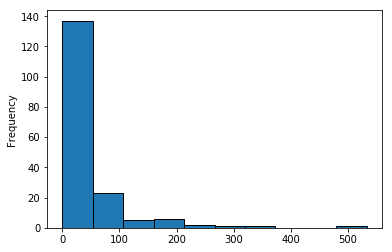

In [474]:
company_full[company_full["week_donation"] <= 550]["week_donation"].plot(kind = "hist", edgecolor = "black")

In [471]:
company_full[company_full["start_month"] == 6]["week_donation"].max()

533.12800000000004

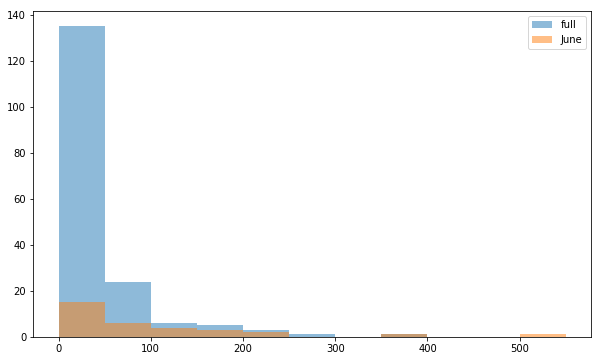

In [473]:
fig, axs = plt.subplots(nrows=1,  figsize = (10,6));
bins = np.linspace(0, 550, 12)
plt.hist(company_full[company_full["week_donation"] <=500]["week_donation"], bins, alpha = 0.5, label = "full");
plt.hist(company_full[company_full["start_month"] == 6]["week_donation"], bins, alpha = 0.5, label = "June");
plt.legend(loc = "upper right")
plt.show()

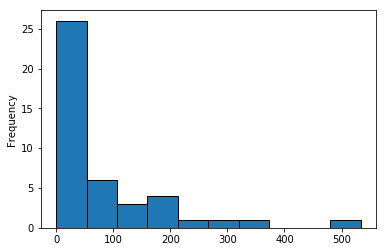

In [449]:
company_full[(company_full["size"] == 500) | (company_full["size"] == 1000)]["week_donation"].plot(kind = "hist", edgecolor = "black")

In [369]:
underdeveloped = pd.read_csv("underdeveloped.csv")
underdeveloped = underdeveloped.drop("Unnamed: 0", axis = 1)
random20 = pd.read_csv("random20.csv")
random20 = random20.drop("Unnamed: 0", axis = 1)

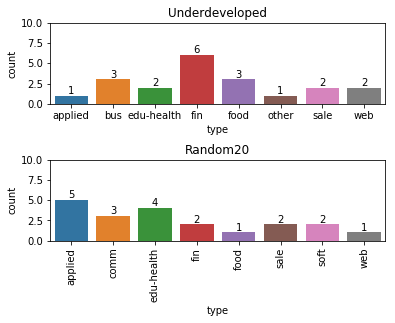

In [392]:
fig, axs = plt.subplots(nrows=2)
axs[0].set_ylim(0,10)
axs[1].set_ylim(0,10)
sns.countplot(
    x=underdeveloped["type"].sort_values(),
    ax=axs[0]
).set_title("Underdeveloped")

sns.countplot(
    x=random20["type"].sort_values(),
    ax=axs[1]
).set_title("Random20")

# Label the bars with counts
for patch in axs[0].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[0].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
#axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.7)


In [418]:
company_full[company_full["state_underdeveloped"] == 1]

,company,avg_donation,last_donation,last_donation_weeks,min_donation,multi_donor,num_donation,num_weeks,popular_month_frac,popular_weekday_frac,...,type_applied,type_bus,type_comm,type_edu-health,type_fin,type_food,type_other,type_sale,type_soft,type_web
25,CA VENTURES suite 2100,44.12500,48.0,0,11.0,1,8,17,0.375000,0.875000,...,0,0,0,0,1,0,0,0,0,0
86,Hygge,20.00000,20.0,10,20.0,0,1,11,1.000000,1.000000,...,0,0,0,0,1,0,0,0,0,0
95,Livongo,16.53913,2.0,0,2.0,1,115,28,0.226087,0.304348,...,0,0,0,1,0,0,0,0,0,0
143,Simply Good Jars,30.00000,30.0,23,30.0,0,1,24,1.000000,1.000000,...,0,0,0,0,0,1,0,0,0,0
155,Toast Inc.,400.00000,400.0,16,400.0,0,1,17,1.000000,1.000000,...,0,0,0,0,0,1,0,0,0,0


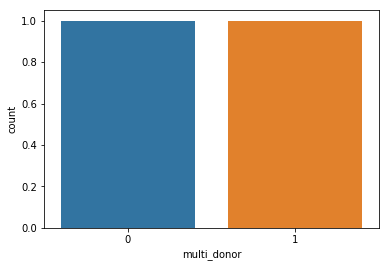

In [415]:
sns.countplot(company_full[(company_full["type_fin"] == 1) & (company_full["state_underdeveloped"] == 1)]["multi_donor"])

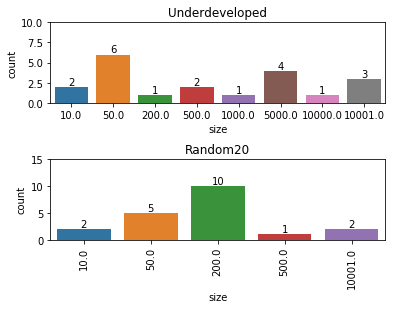

In [391]:
fig, axs = plt.subplots(nrows=2)
axs[0].set_ylim(0,10)
axs[1].set_ylim(0,15)
sns.countplot(
    x=underdeveloped["size"].sort_values(),
    ax=axs[0]
).set_title("Underdeveloped")

sns.countplot(
    x=random20["size"].sort_values(),
    ax=axs[1]
).set_title("Random20")

# Label the bars with counts
for patch in axs[0].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[0].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
#axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.7)


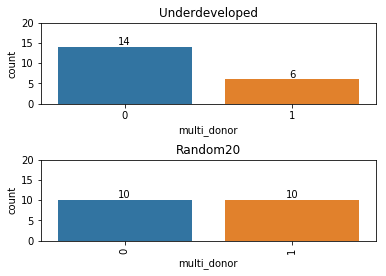

In [394]:
fig, axs = plt.subplots(nrows=2)
axs[0].set_ylim(0,20)
axs[1].set_ylim(0,20)
sns.countplot(
    x=underdeveloped["multi_donor"].sort_values(),
    ax=axs[0]
).set_title("Underdeveloped")

sns.countplot(
    x=random20["multi_donor"].sort_values(),
    ax=axs[1]
).set_title("Random20")

# Label the bars with counts
for patch in axs[0].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[0].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
#axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.7)


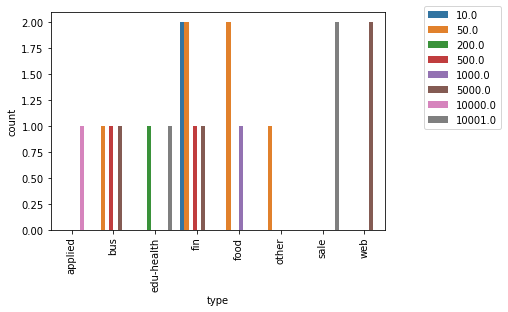

In [409]:
ax = sns.countplot(x = "type", hue = "size", data = underdeveloped.sort_values("type"));
#for patch in ax.patches:
#    x = patch.get_bbox().get_points()[:, 0]
#    y = patch.get_bbox().get_points()[1, 1]
#    ax.annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90);
ax.legend(bbox_to_anchor=(1.1, 1.05));
plt.title("")

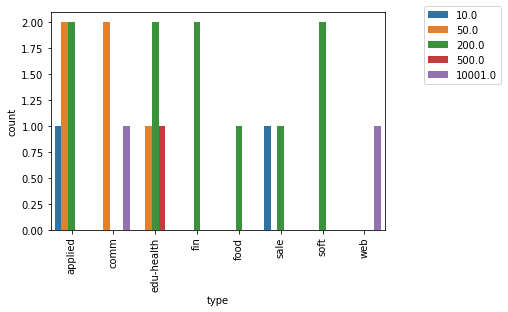

In [411]:
ax = sns.countplot(x = "type", hue = "size", data = random20.sort_values("type"));
#for patch in ax.patches:
#    x = patch.get_bbox().get_points()[:, 0]
#    y = patch.get_bbox().get_points()[1, 1]
#    ax.annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90);
ax.legend(bbox_to_anchor=(1.1, 1.05));